# Flower Identifier

In [92]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm as notebook_tqdm
import matplotlib.pyplot as plt

In [93]:
dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
train_dataset, test_dataset, val_dataset = dataset['train'], dataset['test'], dataset['validation']

In [94]:
# Dataset size and class information
num_training = info.splits['train'].num_examples
num_validation = info.splits['validation'].num_examples
num_test = info.splits['test'].num_examples

print(f'Training set size: {num_training}')
print(f'Validation set size: {num_validation}')
print(f'Test set size: {num_test}')

num_classes = info.features['label'].num_classes
print(f'Number of Classes: {num_classes}')

Training set size: 1020
Validation set size: 1020
Test set size: 6149
Number of Classes: 102


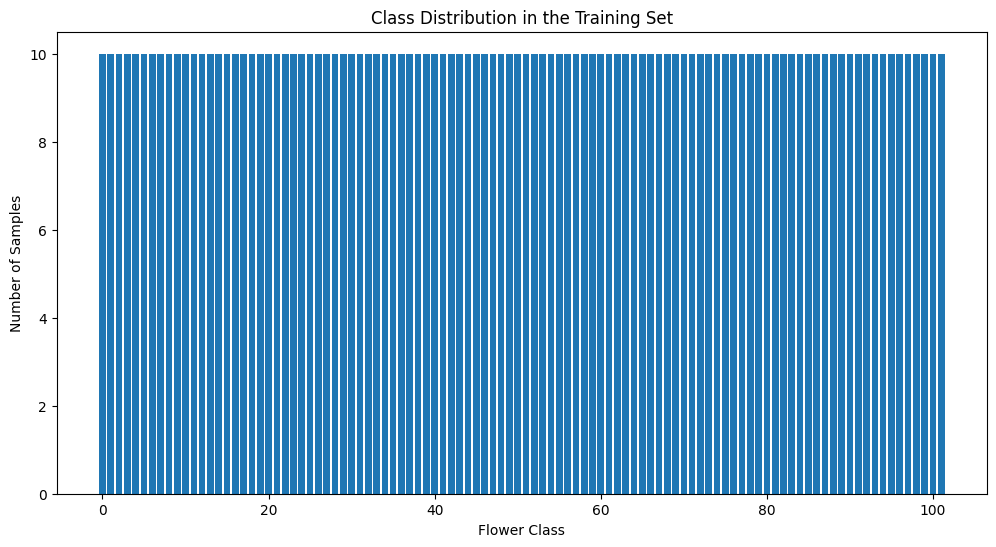

In [95]:
labels = []
for _, label in train_dataset:
    labels.append(label.numpy())

unique_labels, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(12, 6))
plt.bar(unique_labels, counts)
plt.xlabel('Flower Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in the Training Set')
plt.show()

2025-03-15 14:28:51.336820: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


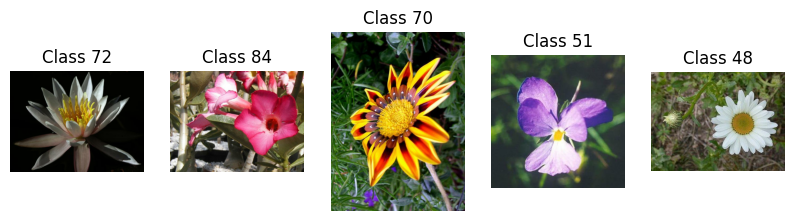

In [96]:
# Function to display random images
def plot_random_images(dataset, num_images=5):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i+1)
        plt.imshow(image.numpy())
        plt.axis('off')
        plt.title(f'Class {label.numpy()}')
    plt.show()

# Display random images from the training set
plot_random_images(train_dataset)

In [97]:
IMG_SIZE = 224

def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize the image to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the pixel values to [0, 1]
    return image, label

In [102]:
# Data augmentation pipeline for training data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),  # Flip horizontally
    tf.keras.layers.RandomRotation(0.2),      # Rotate by a random angle
    tf.keras.layers.RandomZoom(0.2),          # Zoom in or out by a random factor
])

In [103]:
BATCH_SIZE = 32

train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))  # Apply augmentation
train_dataset = train_dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


val_dataset = val_dataset.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Label: 72


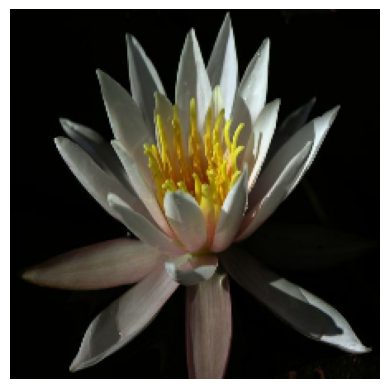

In [100]:
# Check a sample image after preprocessing
for image, label in train_dataset.take(1):  # Take 1 batch
    print(f'Label: {label.numpy()}')
    plt.imshow(image.numpy())
    plt.axis('off')
    plt.show()

In [83]:
# Load model
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [84]:
# Freeze the base model
base_model.trainable = False

# Build the final model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(102, activation='softmax')
])

In [85]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [86]:
history = model.fit(
    train_dataset,
    epochs=11,
    validation_data=val_dataset
)

Epoch 1/11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.0563 - loss: 4.7350

KeyboardInterrupt: 

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

193/193 ━━━━━━━━━━━━━━━━━━━━ 91s 472ms/step - accuracy: 0.7910 - loss: 0.8434
Test accuracy : 0.7911855578422546
